In [4]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [6]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '..dat/data'
annotation_csv = '..dat/data/annotation.csv'

In [7]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

## Get Sample

In [8]:
transform = torchvision.transforms.ToTensor()

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, 
                                      scene_index=labeled_scene_index, 
                                      first_dim='sample', 
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, 
                                          batch_size=3, 
                                          shuffle=True, 
                                          num_workers=2)

In [9]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([3, 6, 3, 256, 306])


## Get individual image

In [10]:
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='image', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=2, shuffle=True, num_workers=2)

In [11]:
# [batch_size, 3, H, W]
image, camera_index = iter(trainloader).next()
print(image.shape)

torch.Size([2, 3, 256, 306])


In [12]:
# Camera_index is to tell you which camera is used. The order is
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
print(camera_index[0])

tensor(2)


# Labeled dataset

In [13]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [14]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


## Evaluation Metric (Threat Score)

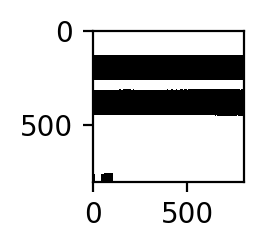

In [15]:
matplotlib.rcParams['figure.figsize'] = [1, 1]
plt.imshow(road_image[0],cmap = 'binary')

In [16]:
random_tensor = torch.rand((2,800,800))


In [17]:
# Create example tensor to represent model's binary prediction output
# Filling in values so that we can clearly see True Positives, etc. in the plots
random_tensor = torch.randn((2,800,800))
random_tensor[0][:300,:800].fill_(1)
random_tensor[0][:150,:800].fill_(0)

tensor = torch.full((2,800,800),0)
tensor[random_tensor >= 0.5] = 1

pred_tensor = tensor


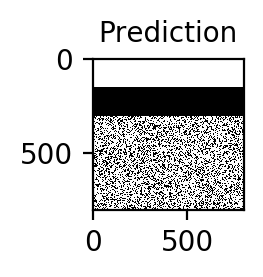

In [18]:
# Visualize Prediction
plt.figure()
plt.title("Prediction", fontsize = 10)
plt.imshow(pred_tensor[0],cmap = 'binary');


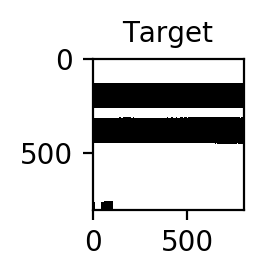

In [19]:
# Visualize target
plt.figure()
plt.title("Target", fontsize = 10)
plt.imshow(road_image[0],cmap = 'binary');

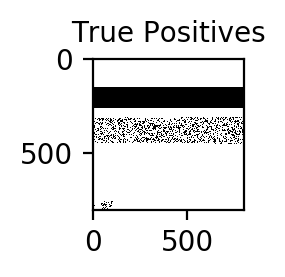

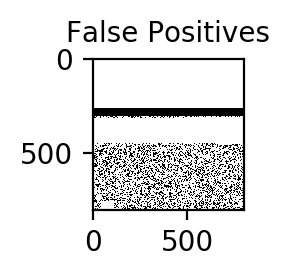

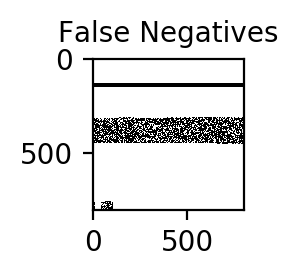

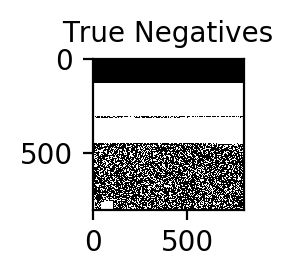

In [20]:
# Visualize True Positives, False Positives, False Negatives, True Negatives
TP_tensor = torch.mul(pred_tensor[0],road_image[0])

plt.figure()
plt.title("True Positives", fontsize = 10)
plt.imshow(TP_tensor,cmap = 'binary');

FP_tensor = torch.add(pred_tensor[0], TP_tensor, alpha = -1)

plt.figure()
plt.title("False Positives", fontsize = 10)
plt.imshow(FP_tensor,cmap = 'binary');

FN_tensor = torch.add(road_image[0], TP_tensor, alpha = -1)

plt.figure()
plt.title("False Negatives", fontsize = 10)
plt.imshow(FN_tensor, cmap = 'binary');

# TN = Condition negative - FP
Negatives_tensor = torch.add(torch.ones(road_image[0].shape), road_image[0], alpha = -1) 
TN_tensor = torch.add(Negatives_tensor, FP_tensor, alpha = -1) 

plt.figure()
plt.title("True Negatives", fontsize = 10)
plt.imshow(TN_tensor, cmap = 'binary');

In [21]:
def threat_score(prediction, target):
    """
    Inputs:
    prediction: (batch_size, 800,800) tensor with entries in {0,1}
    target: (batch_size,800,800) tensor with entries in {0,1} 
    
    Calculates TP, FP, FN
    
    Output:
    Average threat score 
    """
    
    n = torch.stack(target).shape[0]
    
    # Initialize
    sum_ts = 0
    
    for i in range(n):
        # prediction * target = true positive
        tp_tensor = torch.mul(prediction[i],target[i])

        # prediction - true positive = false positive
        fp_tensor = torch.add(prediction[i], tp_tensor[i], alpha = -1)

        # target - true positive = false negative
        fn_tensor = torch.add(target[i], tp_tensor[i], alpha = -1)
        
        tp = np.int(torch.sum(tp_tensor))
        fp = np.int(torch.sum(fp_tensor))
        fn = np.int(torch.sum(fn_tensor))

        # threat score
        ts = tp/(tp + fp + fn)
        
        sum_ts += ts

    sum_ts /= n

    return sum_ts


In [22]:
threat_score(pred_tensor, road_image)

0.18289833947594364